In [1]:
import os; os.chdir('..')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
import glob
warnings.simplefilter('ignore')

from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook

import glob

from scripts import datasources, models, variables

mm.initialize()

Registering model step 'auto_ownership'
Registering model step 'primary_mode_choice'


In [2]:
@orca.table(cache=False)
def nodessmall():
    df = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
    df.rename(columns = {'osmid':'node_id_small'}, inplace = True)
    df.set_index('node_id_small',inplace = True)
    return df

@orca.table(cache=False)
def nodeswalk():
    df = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
    df.rename(columns = {'osmid':'node_id_walk'}, inplace = True)
    df.set_index('node_id_walk',inplace = True)
    return df


#initialization only
orca.run(['initialize_network_small','initialize_network_walk'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


# Generate synthpop table for simulation

In [7]:
d = '/home/jayne/activitysynth/'
@orca.table()
def persons_CHTS_format():
# use persons with jobs for persons
    persons_with_job = pd.read_csv(d+'data/persons_w_jobs.csv')
    persons_with_TOD = orca.get_table('persons').to_frame()[['person_id','TOD']]

    hh_df = orca.get_table('households').to_frame()[['household_id','cars','tenure','income','persons','building_id']]
    jobs_df = orca.get_table('jobs').to_frame()[['job_id','building_id']]
    buildings_df = orca.get_table('buildings')[['building_id','parcel_id']]
    parcels_df = orca.get_table('parcels')[['parcel_id','zone_id']]

    persons_with_job = persons_with_job[['person_id','sex','age','race_id','worker','edu','household_id','job_id']]

    # merge time of day
    persons_with_job= persons_with_job.merge(persons_with_TOD, how = 'left', on = 'person_id')

    # rename columns/change values to match CHTS
    persons_with_job.columns = ['person_id','GEND','AGE','RACE1','JOBS','EDUCA','household_id','job_id','TOD']
    persons_with_job.RACE1 = persons_with_job.RACE1.map({1:1,2:2,3:3,4:3,5:3,6:4,7:5,8:97,9:97})
    persons_with_job.EDUCA = persons_with_job.EDUCA.map({0:1,1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,
                                                        10:1,11:1,12:1,13:1,14:1,15:1,16:2,17:2,18:3,19:3,
                                                        20:4,21:5,22:6,23:6,24:6})
    persons_with_job.TOD = persons_with_job.TOD.map({2:'EA',3:'EA',12:'AM',14:'AM',22:'MD',23:'MD',24:'MD'})

    # read skim
    skim = pd.read_csv('./data/skims_110118.csv',index_col = 0)

    EA_skim = skim[['orig','dest']+list(skim.filter(like = 'EA').columns)]
    EA_skim.columns = EA_skim.columns.str.replace('_EA','')
    EA_skim['TOD'] = 'EA'
    AM_skim = skim[['orig','dest']+list(skim.filter(like = 'AM').columns)]
    AM_skim.columns = AM_skim.columns.str.replace('_AM','')
    AM_skim['TOD'] = 'AM'
    MD_skim = skim[['orig','dest']+list(skim.filter(like = 'MD').columns)]
    MD_skim.columns = MD_skim.columns.str.replace('_MD','')
    MD_skim['TOD'] = 'MD'

    skim_combined = pd.concat([EA_skim,AM_skim,MD_skim],axis = 1)

    MTC_acc = pd.read_csv('/home/jayne/activitysynth/data/MTC_TAZ_accessibility.csv')

    # merge attributes onto persons
    # want household as origin zone and job as destination zone.

    hh_df = hh_df.merge(buildings, how = 'left', on = 'building_id').merge(parcels_df, how = 'left', on = 'parcel_id')
    hh_df.rename(columns = {'zone_id':'orig'},inplace = True)

    jobs_df = jobs_df.merge(buildings,how = 'left', on = 'building_id').merge(parcels_df, how = 'left', on = 'parcel_id')
    jobs_df.rename(columns = {'zone_id':'dest'}, inplace = True)

    persons_with_job = persons_with_job.merge(hh_df, how = 'left', on = 'household_id').merge(jobs_df, how = 'left',on = 'job_id')

    persons_with_job = persons_with_job.merge(MTC_acc, how = 'left',left_on = 'orig', right_on = 'taz1454')
    persons_with_job[MTC_acc.columns] = persons_with_job[MTC_acc.columns].fillna(0)

    persons_with_job = persons_with_job.merge(skim_combined, how = 'left', on = ['orig','dest','TOD'])

    return persons_with_job

In [35]:
persons_with_job = pd.read_csv(d+'data/persons_w_jobs.csv')
persons_with_TOD = orca.get_table('persons').to_frame().reset_index()[['person_id']]
persons_with_TOD['TOD'] = np.random.choice([2,3,12,14,22,23,24],size = len(persons_with_TOD)) # temporary getaround

hh_df = orca.get_table('households').to_frame().reset_index()[['household_id','cars','tenure','income','persons','building_id']]
jobs_df = orca.get_table('jobs').to_frame().reset_index()[['job_id','building_id']]
buildings_df = orca.get_table('buildings').to_frame().reset_index()[['building_id','parcel_id']]
parcels_df = orca.get_table('parcels').to_frame().reset_index()[['primary_id','zone_id']]

persons_with_job = persons_with_job[['person_id','sex','age','race_id','worker','edu','household_id','job_id']]

# merge time of day
persons_with_job= persons_with_job.merge(persons_with_TOD, how = 'left', on = 'person_id')

# rename columns/change values to match CHTS
persons_with_job.columns = ['person_id','GEND','AGE','RACE1','JOBS','EDUCA','household_id','job_id','TOD']
persons_with_job.RACE1 = persons_with_job.RACE1.map({1:1,2:2,3:3,4:3,5:3,6:4,7:5,8:97,9:97})
persons_with_job.EDUCA = persons_with_job.EDUCA.map({0:1,1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,
                                                    10:1,11:1,12:1,13:1,14:1,15:1,16:2,17:2,18:3,19:3,
                                                    20:4,21:5,22:6,23:6,24:6})
persons_with_job.TOD = persons_with_job.TOD.map({2:'EA',3:'EA',12:'AM',14:'AM',22:'MD',23:'MD',24:'MD'})




In [36]:
# read skim
skim = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/skims_110118.csv',index_col = 0)

EA_skim = skim[['orig','dest']+list(skim.filter(like = 'EA').columns)]
EA_skim.columns = EA_skim.columns.str.replace('_EA','')
EA_skim['TOD'] = 'EA'
AM_skim = skim[['orig','dest']+list(skim.filter(like = 'AM').columns)]
AM_skim.columns = AM_skim.columns.str.replace('_AM','')
AM_skim['TOD'] = 'AM'
MD_skim = skim[['orig','dest']+list(skim.filter(like = 'MD').columns)]
MD_skim.columns = MD_skim.columns.str.replace('_MD','')
MD_skim['TOD'] = 'MD'

skim_combined = pd.concat([EA_skim,AM_skim,MD_skim])



In [37]:
MTC_acc = pd.read_csv(d+'data/MTC_TAZ_accessibility.csv')

parcels_df.rename(columns = {'primary_id':'parcel_id'}, inplace = True)



In [38]:
# merge attributes onto persons
# want household as origin zone and job as destination zone.

hh_df = hh_df.merge(buildings_df, how = 'left', on = 'building_id').merge(parcels_df, how = 'left', on = 'parcel_id')
hh_df.rename(columns = {'zone_id':'orig'},inplace = True)

jobs_df = jobs_df.merge(buildings_df,how = 'left', on = 'building_id').merge(parcels_df, how = 'left', on = 'parcel_id')
jobs_df.rename(columns = {'zone_id':'dest'}, inplace = True)



In [39]:
hh_df.columns,jobs_df.columns

(Index(['household_id', 'cars', 'tenure', 'income', 'persons', 'building_id',
        'parcel_id', 'orig'],
       dtype='object'),
 Index(['job_id', 'building_id', 'parcel_id', 'dest'], dtype='object'))

In [ ]:
persons_with_job = persons_with_job.merge(hh_df, how = 'left', on = 'household_id')
persons_with_job.drop(['building_id','parcel_id'],axis = 1,inplace = True)

persons_with_job = persons_with_job.merge(jobs_df, how = 'inner',on = 'job_id')
persons_with_job.drop(['building_id','parcel_id'],axis = 1,inplace = True)

persons_with_job = persons_with_job.merge(MTC_acc, how = 'left',left_on = 'orig', right_on = 'taz1454')
persons_with_job[MTC_acc.columns] = persons_with_job[MTC_acc.columns].fillna(0)


In [52]:
persons_with_job = persons_with_job.merge(skim_combined, how = 'left', on = ['orig','dest','TOD'])


In [53]:

# rename the remaning attributes
persons_with_job['OWN'] = (persons_with_job['tenure']==1).astype(int)
persons_with_job.rename(columns = {'cars':'HHVEH','income':'INCOM','persons':'HHSIZ'},inplace = True)

In [58]:
persons_with_job.dropna(inplace = True)

In [60]:
@orca.table()
def persons_CHTS_format():
    return persons_with_job

# CHTS procedure for estimation

In [62]:
persons_df = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_PER.csv')[
    ['SAMPN','PERNO','GEND', 'AGE', 'RACE1', 'JOBS','EDUCA']
]

In [63]:
hh_df = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_HH.csv')[
  ['SAMPN','HHVEH','OWN','INCOM','HHSIZ']]

In [64]:
persons_df.head()

,SAMPN,PERNO,GEND,AGE,RACE1,JOBS,EDUCA
0,1031985,1,1,74,1.0,NaN,6
1,1031985,2,2,73,1.0,NaN,6
2,1032036,1,1,46,1.0,1.0,6
3,1032036,2,2,47,1.0,NaN,6
4,1032036,3,1,15,1.0,NaN,1


In [65]:
hh_df.head()

,SAMPN,HHVEH,OWN,INCOM,HHSIZ
0,1031985,2,1,3,2
1,1032036,1,1,7,5
2,1032053,2,2,2,6
3,1032425,2,1,7,2
4,1032558,0,2,1,1


In [66]:
# accessibility tables
MTC_acc = pd.read_csv('/home/jayne/ual_model_workspace/fall-2018-models/data/MTC_TAZ_accessibility.csv')

In [67]:
trips_table = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/notebooks-emma/HWtrips_101418.csv',index_col = 0)

trips_table['SAMPN'] = trips_table['HHPER'].astype(str).str.slice(0,-1).astype(int)
trips_table['PERNO'] = trips_table['HHPER'].astype(str).str.slice(-1).astype(int)

trips_table = trips_table.merge(persons_df, on = ['SAMPN','PERNO'], how = 'left').merge(hh_df, on = 'SAMPN', how = 'left')


In [68]:
na_dict = {
    'GEND':[9],
    'AGE':[998,999],
    'RACE1':[97,98,99],
    'JOBS':[98,99],
    'EDUCA':[7,8,9],
    'HHVEH':[98,99],
    'OWN':[7,8,9],
    'INCOM':[98,99],
    'HHSIZ':[98,99]
}

for col in na_dict:
    for vals in na_dict[col]:
        trips_table[col] = trips_table[col].replace(vals,np.nan)
        
trips_table.dropna(inplace = True)

In [69]:
TOD_list = ['EA','AM','MD','PM','EV']
var_list = ['Distance','Cost','Time']
skim_dir = '/home/data/fall_2018/mtc_skims'
skim_dict = dict()
for var in var_list:
    df_base = pd.read_csv(skim_dir + f'/{var}SkimsDatabaseEA.csv').replace(-999, 9999)
    df_base['TOD'] = 'EA'
    for TOD in TOD_list[1:]:
        df_tod = pd.read_csv(skim_dir + f'/{var}SkimsDatabase{TOD}.csv').replace(-999, 9999)
        df_tod['TOD'] = TOD
        df_base = pd.concat([df_base, df_tod])
    skim_dict[var] = df_base
        


# Time of day definitions

• Early (3:00 AM to 5:59 AM)
• AM peak (6:00 AM to 8:59 AM)
• Midday (9:00 AM to 3:29 PM)
• PM peak (3:30 PM to 6:29 PM)
• Late (6:30 PM to 2:59 AM)
EA, AM, MD, PM, EV

In [70]:
mode_dict = dict(zip(['drive_alone', 'shared',
                      'WTranW','DrTranW','WTranDr',
                      'bike', 'walk'],range(7)))
trips_table['MODE'] = trips_table['MODE'].replace(mode_dict)

In [71]:
trips_table['TOD'] = (
    ((trips_table.origin_ET.between(3,6,inclusive = False)) | (trips_table.origin_ET==3))*1 +
    ((trips_table.origin_ET.between(6,9,inclusive = False)) | (trips_table.origin_ET==6))*2 +
    ((trips_table.origin_ET.between(9,15.5,inclusive = False)) | (trips_table.origin_ET==9))*3 +
    ((trips_table.origin_ET.between(15.5,18.5,inclusive = False)) | (trips_table.origin_ET==15.5))*4 +
    ((trips_table.origin_ET>=18.5))*5 +
    ((trips_table.origin_ET.between(0,3,inclusive = False)) | (trips_table.origin_ET==0))*5
)
TOD_dict = dict(zip(range(1,6),TOD_list))
trips_table['TOD'] = trips_table['TOD'].replace(TOD_dict)


In [72]:
trips_table1 = trips_table.copy()
for var in var_list:
    trips_table1 = trips_table1.merge(skim_dict[var].rename(
        columns = dict(zip([i for i in skim_dict[var].columns if i not in ['orig','dest','TOD']],
         [i+ f'_{var}' for i in skim_dict[var].columns if i not in ['orig','dest','TOD']]))                                          
                                           ), how = 'left',left_on = ['Ozone','Dzone','TOD'], 
    right_on = ['orig','dest','TOD'])
    trips_table1.drop(['orig','dest'],axis = 1,inplace = True)

In [73]:
# join accessibility
trips_table1 = trips_table1.merge(MTC_acc, how = 'left',left_on = 'Ozone', right_on = 'taz1454')
trips_table1[MTC_acc.columns] = trips_table1[MTC_acc.columns].fillna(0)

In [82]:
@orca.table(cache=True)
def trips1():
    return trips_table1.set_index('HHPERTRIP')

In [83]:
# mode_dict = dict(zip(['drive_alone', 'shared','WTranW','DrTranW','WTranDr','bike', 'walk'],range(7)))
        
m = SmallMultinomialLogitStep()
m.name = 'primary_mode_choice'
m.tables = ['trips1']
m.choice_column = 'MODE'
m.model_expression = OrderedDict([
        ('intercept', [1,2,3,4,5,6]), 
    ('GEND',[2,3,4,5,6]),
    ('AGE',[2,3,4,5,6]),
    ('RACE1',[2,3,4,5,6]),
    ('JOBS',[2,3,4,5,6]), # equals 1
    ('EDUCA',[2,3,4,5,6]), #recode
    ('HHVEH',[2,3,4,5,6]), # join hh
    ('OWN',[2,3,4,5,6]), #tenure
    ('INCOM',[2,3,4,5,6]),
    ('HHSIZ',[2,3,4,5,6]),
    ('da_Distance',[0]),
    ('da_Cost',[0]),
    ('da_Time',[0]),
    ('da_15',[0]),
    ('s2_Distance',[1]),
    ('s2_Cost',[1]),
    ('s2_Time',[1]),    
    ('da_15',[1]),
    ('wTrnW_Cost',[2]),
    ('wTrnW_Time',[2]),
    ('wTrnW_15',[2]),
    ('dTrnW_Cost',[3]),
    ('dTrnW_Time',[3]),
    ('wTrnD_Time',[4]),
    ('wTrnD_Cost',[5]),
    ('bike_Distance',[5]),
    ('bike_Time',[5]),   
    ('bike_15',[5]),
    ('walk_Distance',[6]),
    ('walk_Time',[6]),  
    ('walk_15',[6])
])

In [84]:
chooser_ids = orca.get_table('trips1').to_frame().sample(5000,random_state = 2).index.values 
m.filters = ['HHPERTRIP in [{0}]'.format(','.join(map(str, chooser_ids)))]

m.fit()

Log-likelihood at zero: -9,729.5507
Initial Log-likelihood: -9,729.5507
Estimation Time for Point Estimation: 4.35 seconds.
Final log-likelihood: -3,589.7646
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:                5,000
Model:             Multinomial Logit Model   Df Residuals:                    4,929
Method:                                MLE   Df Model:                           71
Date:                     Tue, 18 Dec 2018   Pseudo R-squ.:                   0.631
Time:                             03:45:04   Pseudo R-bar-squ.:               0.624
AIC:                             7,321.529   Log-Likelihood:             -3,589.765
BIC:                             7,784.250   LL-Null:                    -9,729.551
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
in

In [87]:
m.run()

In [89]:
dir(m)

['_TemplateStep__out_tables',
 '_TemplateStep__tables',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_generate_name',
 '_get_alts',
 '_get_data',
 '_get_filter_columns',
 '_get_out_column',
 '_get_out_table',
 '_get_param_count',
 '_normalize_table_param',
 '_to_long',
 'choice_column',
 'choices',
 'filters',
 'fit',
 'from_dict',
 'initial_coefs',
 'model',
 'model_expression',
 'model_labels',
 'name',
 'out_column',
 'out_filters',
 'out_tables',
 'out_transform',
 'probabilities',
 'run',
 'summary_table',
 'tables',
 'tags',
 'template',
 'template_version',
 'to_dict']

In [90]:
mm.save_step_to_disk(m)

Saving 'primary_mode_choice.yaml': /home/jayne/ual_model_workspace/fall-2018-models/configs
Model saved to configs/primary_mode_choice-model-object.pkl


In [88]:
m.tags = ['mode_choice','jayne','test']
mm.save_step_to_disk(m)

AttributeError: 'SmallMultinomialLogitStep' object has no attribute 'register'

In [18]:
# Validation process
from scripts import validate
validate.tp_rates(m)

,0,1,2,3,4,5,6,all
True Positive rate,0.981719,0,0.493952,0.0564516,0.0136986,0.123675,0.176829,0.801791


In [19]:
predicted_choices = validate.get_predicted_choices(m)
pd.crosstab(m.choices.rename('observed'), predicted_choices, margins=True) # unnormalized

predicted,0,2,3,4,5,6,All
observed,,,,,,,
0,6122,77,9,3,16,9,6236
1,390,5,0,0,1,0,396
2,225,245,2,3,7,14,496
3,206,19,14,9,0,0,248
4,191,23,1,3,1,0,219
5,221,21,1,0,35,5,283
6,96,33,0,0,6,29,164
All,7451,423,27,18,66,57,8042


In [20]:
validate.model_crosstab(m) # normalized by index

predicted,0,2,3,4,5,6
observed,,,,,,
0,0.981719,0.012348,0.001443,0.000481,0.002566,0.001443
1,0.984848,0.012626,0.000000,0.000000,0.002525,0.000000
2,0.453629,0.493952,0.004032,0.006048,0.014113,0.028226
3,0.830645,0.076613,0.056452,0.036290,0.000000,0.000000
4,0.872146,0.105023,0.004566,0.013699,0.004566,0.000000
5,0.780919,0.074205,0.003534,0.000000,0.123675,0.017668
6,0.585366,0.201220,0.000000,0.000000,0.036585,0.176829


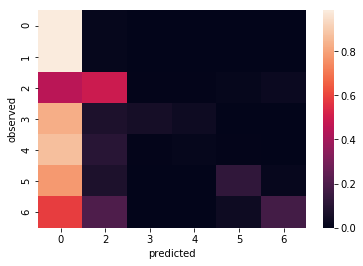

In [21]:
sns.heatmap(validate.model_crosstab(m))